<a href="https://colab.research.google.com/github/MSDS19026/MSDS19026_COVID19_DLSpring2020/blob/master/covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 5 - Part 1** 
## *Detecting Coronavirus Infections through Chest X-Ray images*

### MSDS19026

### Mount Drive

In [1]:
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


### Load Dataset

In [2]:
!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

### Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## User Defined Functions

In [0]:
def Model_results(loader):

  if loader == trainloader:
    print("~*Loading Results for Training*~\n\n\n")
  elif loader == validloader:
    print("~*Loading Results for Validation*~\n\n\n")
  elif loader == testloader:
    print("~*Loading Results for Testing*~\n\n\n")
  
  total=0
  true_normal=0
  true_infected=0
  false_normal=0
  false_infected=0
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          for i in range(len(images)):
             if(class_names[predicted[i]]=="normal"):
                true_normal += (predicted[i] == labels[i]).item()
                false_normal += (predicted[i] != labels[i]).item()
             elif(class_names[predicted[i]]=="infected"):
              true_infected += (predicted[i] == labels[i]).item()
              false_infected += (predicted[i] != labels[i]).item() 

  correct= true_infected+true_normal
  precision = true_normal/(true_normal+false_normal)
  recall = true_normal/(true_normal+false_infected)
  F1_score = (2*precision*recall)/(precision+recall)
  print('True Normal:', true_normal)
  print('True Infected:', true_infected)
  print('False Normal:', false_normal)
  print('False Infected:', false_infected)
  print('Precision:',precision)
  print('Recall:', recall)
  print('F1 Score:', F1_score)
  print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
  CM = np.array([[true_normal,false_infected], [false_normal, true_infected]])
  plt.figure(figsize = (10,7))
  ax= plt.subplot()
  sn.heatmap(CM,cmap="Blues", annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['Normal', 'Infected']); ax.yaxis.set_ticklabels(['Normal', 'Infected']);



In [0]:
def resnet_Model_results(loader):

  if loader == trainloader:
    print("~*Loading Results for Training*~\n\n\n")
  elif loader == validloader:
    print("~*Loading Results for Validation*~\n\n\n")
  elif loader == testloader:
    print("~*Loading Results for Testing*~\n\n\n")
  
  total=0
  true_normal=0
  true_infected=0
  false_normal=0
  false_infected=0
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          for i in range(len(images)):
             if(class_names[predicted[i]]=="normal"):
                true_normal += (predicted[i] == labels[i]).item()
                false_normal += (predicted[i] != labels[i]).item()
             elif(class_names[predicted[i]]=="infected"):
              true_infected += (predicted[i] == labels[i]).item()
              false_infected += (predicted[i] != labels[i]).item() 

  correct= true_infected+true_normal
  precision = true_normal/(true_normal+false_normal)
  recall = true_normal/(true_normal+false_infected)
  F1_score = (2*precision*recall)/(precision+recall)
  print('True Normal:', true_normal)
  print('True Infected:', true_infected)
  print('False Normal:', false_normal)
  print('False Infected:', false_infected)
  print('Precision:',precision)
  print('Recall:', recall)
  print('F1 Score:', F1_score)
  print('Accuracy of the network on the images: %d %%' % (100 * correct / total))
  CM = np.array([[true_normal,false_infected], [false_normal, true_infected]])
  plt.figure(figsize = (10,7))
  ax= plt.subplot()
  sn.heatmap(CM,cmap="Blues", annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['Normal', 'Infected']); ax.yaxis.set_ticklabels(['Normal', 'Infected']);



### Loading and normalizing X-Rays

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('Assignment 5 Dataset/train', transform=train_transforms)
valid_data = datasets.ImageFolder('Assignment 5 Dataset/validation', transform=valid_transforms)
test_data = datasets.ImageFolder('Assignment 5 Dataset/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers =4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True,num_workers =4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,num_workers =4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


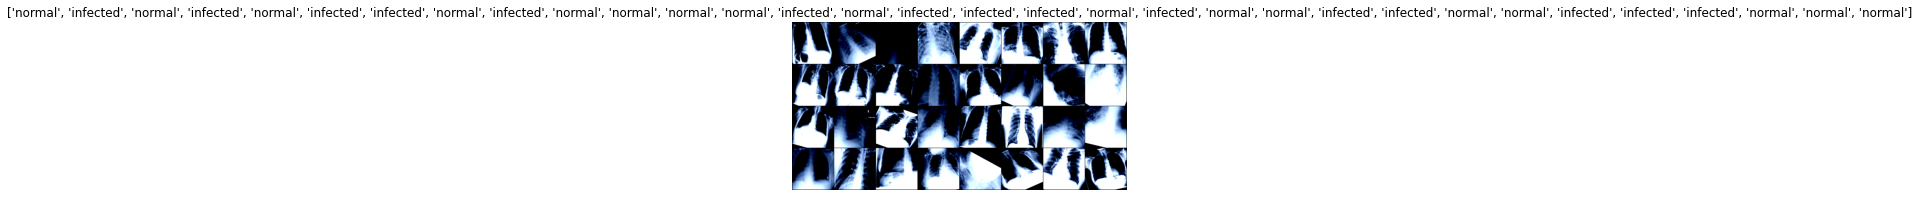

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Task 1: VGG-16

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Removing FC Layers

In [0]:
num_features = vgg16.classifier[0].in_features
print(num_features)

25088


In [0]:
features = list(vgg16.classifier.children())[:0] # Remove last layer
print(features)

[]


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

### Adding New layers

In [0]:
roll_num_features = (26*10)+100
features.extend([nn.Linear(num_features, roll_num_features)])
features.extend([nn.Linear(roll_num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.004, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics

        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * correct / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')


    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * correct / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.417812: : 375it [03:32,  1.77it/s]


Accuracy: 85 %


Valid Epoch: 0 [1288/1500 (98%)]	Loss: 0.313267: : 47it [00:22,  2.11it/s]

Accuracy: 88 %



Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.304239: : 375it [03:27,  1.81it/s]


Accuracy: 89 %


Valid Epoch: 1 [1288/1500 (98%)]	Loss: 0.404187: : 47it [00:21,  2.15it/s]

Accuracy: 90 %



Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.131149: : 375it [03:26,  1.82it/s]


Accuracy: 89 %


Valid Epoch: 2 [1288/1500 (98%)]	Loss: 0.263883: : 47it [00:20,  2.24it/s]

Accuracy: 90 %



Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.223496: : 375it [03:23,  1.84it/s]


Accuracy: 90 %


Valid Epoch: 3 [1288/1500 (98%)]	Loss: 0.224674: : 47it [00:20,  2.25it/s]

Accuracy: 91 %



Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.255409: : 375it [03:23,  1.84it/s]


Accuracy: 91 %


Valid Epoch: 4 [1288/1500 (98%)]	Loss: 0.250689: : 47it [00:22,  2.10it/s]

Accuracy: 92 %



Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.305588: : 375it [03:27,  1.81it/s]


Accuracy: 91 %


Valid Epoch: 5 [1288/1500 (98%)]	Loss: 0.289623: : 47it [00:21,  2.22it/s]

Accuracy: 91 %



Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.299252: : 375it [03:26,  1.81it/s]


Accuracy: 91 %


Valid Epoch: 6 [1288/1500 (98%)]	Loss: 0.310129: : 47it [00:22,  2.13it/s]

Accuracy: 91 %



Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.340071: : 375it [03:32,  1.77it/s]


Accuracy: 91 %


Valid Epoch: 7 [1288/1500 (98%)]	Loss: 0.317911: : 47it [00:22,  2.13it/s]

Accuracy: 91 %



Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.094267: : 375it [03:36,  1.73it/s]


Accuracy: 91 %


Valid Epoch: 8 [1288/1500 (98%)]	Loss: 0.304235: : 47it [00:22,  2.11it/s]

Accuracy: 91 %



Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.126269: : 375it [03:32,  1.76it/s]


Accuracy: 92 %


Valid Epoch: 9 [1288/1500 (98%)]	Loss: 0.204422: : 47it [00:21,  2.19it/s]

Accuracy: 91 %
Finished Training


### Plotting Accuracy & Loss

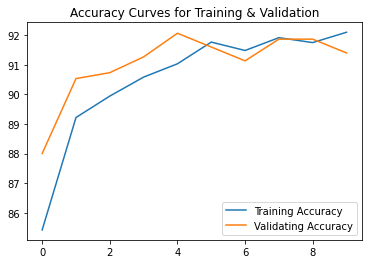

In [0]:

plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

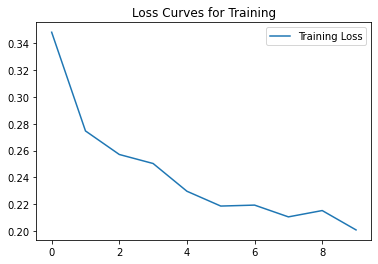

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


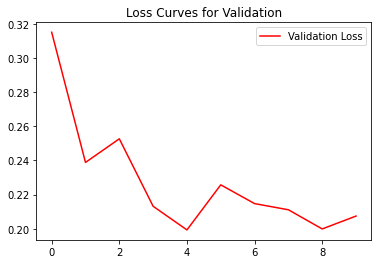

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


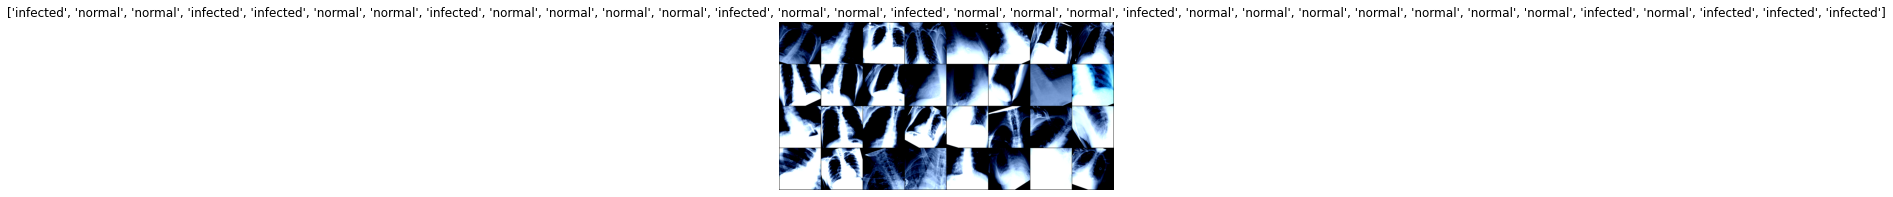

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Training*~



True Normal: 6922
True Infected: 4130
False Normal: 789
False Infected: 159
Precision: 0.8976786409026066
Recall: 0.9775455444146307
F1 Score: 0.9359113034072472
Accuracy of the network on the images: 92 %


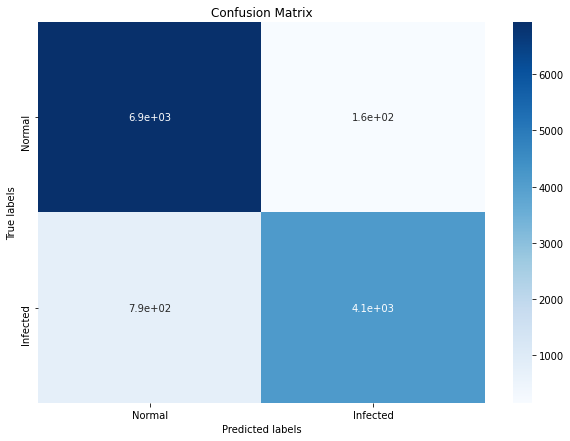

In [0]:
Model_results(trainloader)

### Validation Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


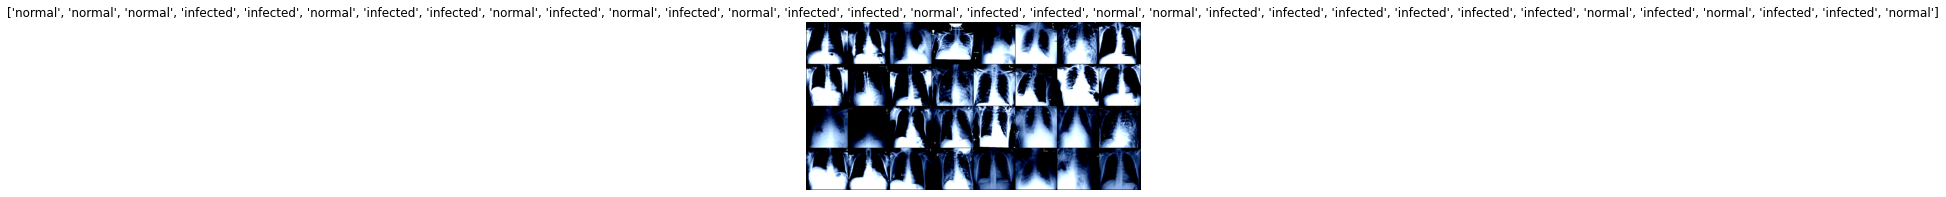

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Validation*~



True Normal: 856
True Infected: 515
False Normal: 100
False Infected: 29
Precision: 0.895397489539749
Recall: 0.9672316384180791
F1 Score: 0.9299293862031505
Accuracy of the network on the images: 91 %


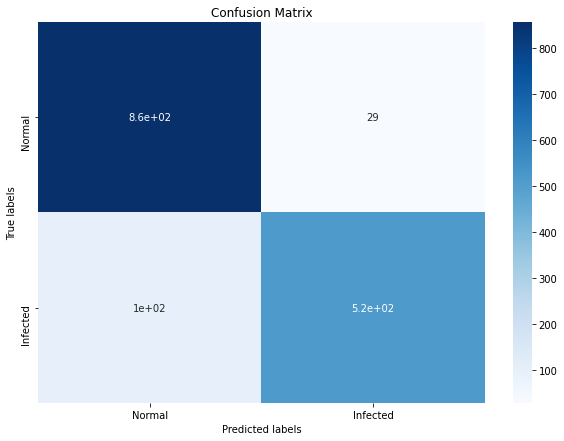

In [0]:
Model_results(validloader)

### Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


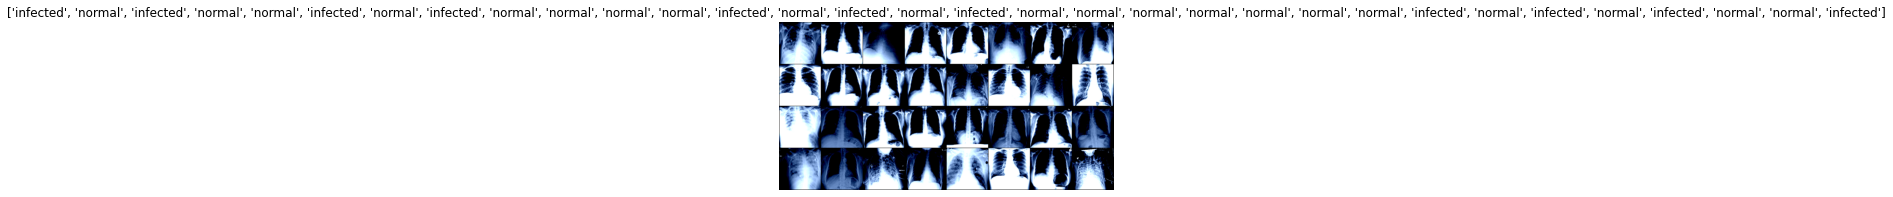

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Testing*~



True Normal: 877
True Infected: 571
False Normal: 44
False Infected: 8
Precision: 0.9522258414766558
Recall: 0.9909604519774011
F1 Score: 0.9712070874861573
Accuracy of the network on the images: 96 %


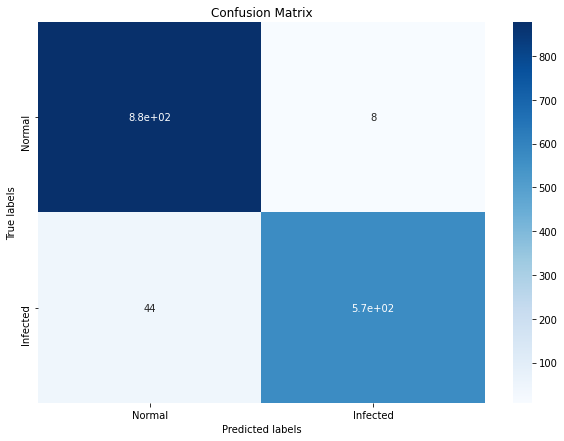

In [0]:
Model_results(testloader)

In [0]:
torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

## Task1: ResNet-18

### Loading Pretrained Model

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained= True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Replacing FC layers

In [0]:
num_features = resnet18.fc.in_features
roll_num_features = (26*10)+100
features.extend([nn.Linear(num_features, roll_num_features)])
features.extend([nn.Linear(roll_num_features, len(class_names))])
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freezing the layers

In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
    param.require_grad = False

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.004, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics

        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * correct / len(train_data))
    train_loss.append(running_loss)
    print('Train Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')


    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * correct / len(valid_data))
    valid_loss.append(running_loss)
    print('Valid Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Streaming output truncated to the last 5000 lines.






Train Epoch: 0 [1472/12000 (12%)]	Loss: 0.301928: : 47it [00:25,  1.70it/s]







Train Epoch: 0 [1504/12000 (13%)]	Loss: 0.054565: : 47it [00:26,  1.70it/s]







Train Epoch: 0 [1504/12000 (13%)]	Loss: 0.054565: : 48it [00:26,  2.23it/s]







Train Epoch: 0 [1536/12000 (13%)]	Loss: 0.414486: : 48it [00:27,  2.23it/s]







Train Epoch: 0 [1536/12000 (13%)]	Loss: 0.414486: : 49it [00:27,  1.62it/s]







Train Epoch: 0 [1568/12000 (13%)]	Loss: 0.283774: : 49it [00:27,  1.62it/s]







Train Epoch: 0 [1568/12000 (13%)]	Loss: 0.283774: : 50it [00:27,  2.14it/s]







Train Epoch: 0 [1600/12000 (13%)]	Loss: 0.141009: : 50it [00:27,  2.14it/s]







Train Epoch: 0 [1600/12000 (13%)]	Loss: 0.141009: : 51it [00:27,  1.92it/s]







Train Epoch: 0 [1632/12000 (14%)]	Loss: 0.125323: : 51it [00:27,  1.92it/s]







Train Epoch: 0 [1664/12000 (14%)]	Loss: 0.066878: : 51it [00:29,  1.92it/s]







Train Epoch: 0 [1664/12000 (14

Train Accuracy: 92 %










0it [00:00, ?it/s]







Valid Epoch: 0 [0/1500 (0%)]	Loss: 0.305591: : 0it [00:01, ?it/s]







Valid Epoch: 0 [0/1500 (0%)]	Loss: 0.305591: : 1it [00:01,  1.77s/it]







Valid Epoch: 0 [32/1500 (2%)]	Loss: 0.301674: : 1it [00:01,  1.77s/it]







Valid Epoch: 0 [64/1500 (4%)]	Loss: 0.243223: : 1it [00:02,  1.77s/it]







Valid Epoch: 0 [64/1500 (4%)]	Loss: 0.243223: : 3it [00:02,  1.27s/it]







Valid Epoch: 0 [96/1500 (6%)]	Loss: 0.220321: : 3it [00:02,  1.27s/it]







Valid Epoch: 0 [128/1500 (9%)]	Loss: 0.444888: : 3it [00:03,  1.27s/it]







Valid Epoch: 0 [128/1500 (9%)]	Loss: 0.444888: : 5it [00:03,  1.12s/it]







Valid Epoch: 0 [160/1500 (11%)]	Loss: 0.326212: : 5it [00:03,  1.12s/it]







Valid Epoch: 0 [192/1500 (13%)]	Loss: 0.103037: : 5it [00:03,  1.12s/it]







Valid Epoch: 0 [192/1500 (13%)]	Loss: 0.103037: : 7it [00:03,  1.22it/s]







Valid Epoch: 0 [224/1500 (15%)]	Loss: 0.055175: : 7it [00:03,  1.22it/s]







Valid Epoch: 0 [256/1500 (

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.






Train Epoch: 1 [1408/12000 (12%)]	Loss: 0.077871: : 44it [00:25,  4.17it/s]







Train Epoch: 1 [1408/12000 (12%)]	Loss: 0.077871: : 45it [00:25,  1.47it/s]







Train Epoch: 1 [1440/12000 (12%)]	Loss: 0.245802: : 45it [00:25,  1.47it/s]







Train Epoch: 1 [1472/12000 (12%)]	Loss: 0.209998: : 45it [00:25,  1.47it/s]







Train Epoch: 1 [1472/12000 (12%)]	Loss: 0.209998: : 47it [00:25,  1.98it/s]







Train Epoch: 1 [1504/12000 (13%)]	Loss: 0.153440: : 47it [00:25,  1.98it/s]







Train Epoch: 1 [1536/12000 (13%)]	Loss: 0.199457: : 47it [00:27,  1.98it/s]







Train Epoch: 1 [1536/12000 (13%)]	Loss: 0.199457: : 49it [00:27,  1.59it/s]







Train Epoch: 1 [1568/12000 (13%)]	Loss: 0.204456: : 49it [00:27,  1.59it/s]







Train Epoch: 1 [1568/12000 (13%)]	Loss: 0.204456: : 50it [00:27,  2.10it/s]







Train Epoch: 1 [1600/12000 (13%)]	Loss: 0.195668: : 50it [00:27,  2.10it/s]







Train Epoch: 1 [1600/12000 (13

Train Accuracy: 92 %










0it [00:00, ?it/s]







Valid Epoch: 1 [0/1500 (0%)]	Loss: 0.162657: : 0it [00:01, ?it/s]







Valid Epoch: 1 [0/1500 (0%)]	Loss: 0.162657: : 1it [00:01,  1.65s/it]







Valid Epoch: 1 [32/1500 (2%)]	Loss: 0.469273: : 1it [00:02,  1.65s/it]







Valid Epoch: 1 [32/1500 (2%)]	Loss: 0.469273: : 2it [00:02,  1.27s/it]







Valid Epoch: 1 [64/1500 (4%)]	Loss: 0.171083: : 2it [00:02,  1.27s/it]







Valid Epoch: 1 [96/1500 (6%)]	Loss: 0.180135: : 2it [00:02,  1.27s/it]







Valid Epoch: 1 [96/1500 (6%)]	Loss: 0.180135: : 4it [00:02,  1.10it/s]







Valid Epoch: 1 [128/1500 (9%)]	Loss: 0.160486: : 4it [00:03,  1.10it/s]







Valid Epoch: 1 [128/1500 (9%)]	Loss: 0.160486: : 5it [00:03,  1.00s/it]







Valid Epoch: 1 [160/1500 (11%)]	Loss: 0.168254: : 5it [00:03,  1.00s/it]







Valid Epoch: 1 [160/1500 (11%)]	Loss: 0.168254: : 6it [00:03,  1.27it/s]







Valid Epoch: 1 [192/1500 (13%)]	Loss: 0.489556: : 6it [00:03,  1.27it/s]







Valid Epoch: 1 [192/1500 (13

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.






Train Epoch: 2 [1600/12000 (13%)]	Loss: 0.214392: : 50it [00:27,  1.33it/s]







Train Epoch: 2 [1600/12000 (13%)]	Loss: 0.214392: : 51it [00:27,  1.79it/s]







Train Epoch: 2 [1632/12000 (14%)]	Loss: 0.118996: : 51it [00:27,  1.79it/s]







Train Epoch: 2 [1664/12000 (14%)]	Loss: 0.163709: : 51it [00:28,  1.79it/s]







Train Epoch: 2 [1664/12000 (14%)]	Loss: 0.163709: : 53it [00:28,  2.19it/s]







Train Epoch: 2 [1696/12000 (14%)]	Loss: 0.157616: : 53it [00:29,  2.19it/s]







Train Epoch: 2 [1696/12000 (14%)]	Loss: 0.157616: : 54it [00:29,  1.31it/s]







Train Epoch: 2 [1728/12000 (14%)]	Loss: 0.183092: : 54it [00:29,  1.31it/s]







Train Epoch: 2 [1728/12000 (14%)]	Loss: 0.183092: : 55it [00:29,  1.74it/s]







Train Epoch: 2 [1760/12000 (15%)]	Loss: 0.293784: : 55it [00:29,  1.74it/s]







Train Epoch: 2 [1760/12000 (15%)]	Loss: 0.293784: : 56it [00:29,  2.28it/s]







Train Epoch: 2 [1792/12000 (15

Train Accuracy: 92 %










0it [00:00, ?it/s]







Valid Epoch: 2 [0/1500 (0%)]	Loss: 0.225960: : 0it [00:01, ?it/s]







Valid Epoch: 2 [0/1500 (0%)]	Loss: 0.225960: : 1it [00:01,  1.84s/it]







Valid Epoch: 2 [32/1500 (2%)]	Loss: 0.392464: : 1it [00:01,  1.84s/it]







Valid Epoch: 2 [64/1500 (4%)]	Loss: 0.172996: : 1it [00:01,  1.84s/it]







Valid Epoch: 2 [64/1500 (4%)]	Loss: 0.172996: : 3it [00:01,  1.31s/it]







Valid Epoch: 2 [96/1500 (6%)]	Loss: 0.452506: : 3it [00:02,  1.31s/it]







Valid Epoch: 2 [128/1500 (9%)]	Loss: 0.097603: : 3it [00:03,  1.31s/it]







Valid Epoch: 2 [128/1500 (9%)]	Loss: 0.097603: : 5it [00:03,  1.15s/it]







Valid Epoch: 2 [160/1500 (11%)]	Loss: 0.198618: : 5it [00:03,  1.15s/it]







Valid Epoch: 2 [192/1500 (13%)]	Loss: 0.182196: : 5it [00:03,  1.15s/it]







Valid Epoch: 2 [192/1500 (13%)]	Loss: 0.182196: : 7it [00:03,  1.21it/s]







Valid Epoch: 2 [224/1500 (15%)]	Loss: 0.132653: : 7it [00:03,  1.21it/s]







Valid Epoch: 2 [256/1500 (

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.






Train Epoch: 3 [1056/12000 (9%)]	Loss: 0.155913: : 33it [00:18,  2.11it/s]







Train Epoch: 3 [1056/12000 (9%)]	Loss: 0.155913: : 34it [00:18,  2.57it/s]







Train Epoch: 3 [1088/12000 (9%)]	Loss: 0.196413: : 34it [00:19,  2.57it/s]







Train Epoch: 3 [1088/12000 (9%)]	Loss: 0.196413: : 35it [00:19,  1.62it/s]







Train Epoch: 3 [1120/12000 (9%)]	Loss: 0.162591: : 35it [00:19,  1.62it/s]







Train Epoch: 3 [1120/12000 (9%)]	Loss: 0.162591: : 36it [00:19,  2.16it/s]







Train Epoch: 3 [1152/12000 (10%)]	Loss: 0.105618: : 36it [00:20,  2.16it/s]







Train Epoch: 3 [1152/12000 (10%)]	Loss: 0.105618: : 37it [00:20,  2.08it/s]







Train Epoch: 3 [1184/12000 (10%)]	Loss: 0.131767: : 37it [00:20,  2.08it/s]







Train Epoch: 3 [1184/12000 (10%)]	Loss: 0.131767: : 38it [00:20,  2.56it/s]







Train Epoch: 3 [1216/12000 (10%)]	Loss: 0.116485: : 38it [00:21,  2.56it/s]







Train Epoch: 3 [1216/12000 (10%)]	Lo

Train Accuracy: 92 %










0it [00:00, ?it/s]







Valid Epoch: 3 [0/1500 (0%)]	Loss: 0.223247: : 0it [00:01, ?it/s]







Valid Epoch: 3 [0/1500 (0%)]	Loss: 0.223247: : 1it [00:01,  1.80s/it]







Valid Epoch: 3 [32/1500 (2%)]	Loss: 0.128019: : 1it [00:01,  1.80s/it]







Valid Epoch: 3 [64/1500 (4%)]	Loss: 0.167882: : 1it [00:01,  1.80s/it]







Valid Epoch: 3 [64/1500 (4%)]	Loss: 0.167882: : 3it [00:01,  1.29s/it]







Valid Epoch: 3 [96/1500 (6%)]	Loss: 0.163227: : 3it [00:02,  1.29s/it]







Valid Epoch: 3 [128/1500 (9%)]	Loss: 0.252000: : 3it [00:03,  1.29s/it]







Valid Epoch: 3 [128/1500 (9%)]	Loss: 0.252000: : 5it [00:03,  1.13s/it]







Valid Epoch: 3 [160/1500 (11%)]	Loss: 0.127147: : 5it [00:03,  1.13s/it]







Valid Epoch: 3 [192/1500 (13%)]	Loss: 0.351646: : 5it [00:03,  1.13s/it]







Valid Epoch: 3 [192/1500 (13%)]	Loss: 0.351646: : 7it [00:03,  1.23it/s]







Valid Epoch: 3 [224/1500 (15%)]	Loss: 0.154133: : 7it [00:03,  1.23it/s]







Valid Epoch: 3 [256/1500 (

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.






Train Epoch: 4 [1056/12000 (9%)]	Loss: 0.094070: : 34it [00:18,  2.09it/s]







Train Epoch: 4 [1088/12000 (9%)]	Loss: 0.143254: : 34it [00:18,  2.09it/s]







Train Epoch: 4 [1088/12000 (9%)]	Loss: 0.143254: : 35it [00:18,  2.74it/s]







Train Epoch: 4 [1120/12000 (9%)]	Loss: 0.292396: : 35it [00:19,  2.74it/s]







Train Epoch: 4 [1120/12000 (9%)]	Loss: 0.292396: : 36it [00:19,  1.94it/s]







Train Epoch: 4 [1152/12000 (10%)]	Loss: 0.268099: : 36it [00:20,  1.94it/s]







Train Epoch: 4 [1152/12000 (10%)]	Loss: 0.268099: : 37it [00:20,  1.68it/s]







Train Epoch: 4 [1184/12000 (10%)]	Loss: 0.133341: : 37it [00:20,  1.68it/s]







Train Epoch: 4 [1184/12000 (10%)]	Loss: 0.133341: : 38it [00:20,  2.23it/s]







Train Epoch: 4 [1216/12000 (10%)]	Loss: 0.284202: : 38it [00:20,  2.23it/s]







Train Epoch: 4 [1216/12000 (10%)]	Loss: 0.284202: : 39it [00:20,  2.87it/s]







Train Epoch: 4 [1248/12000 (10%)]	L

Train Accuracy: 92 %










0it [00:00, ?it/s]







Valid Epoch: 4 [0/1500 (0%)]	Loss: 0.080955: : 0it [00:01, ?it/s]







Valid Epoch: 4 [0/1500 (0%)]	Loss: 0.080955: : 1it [00:01,  1.70s/it]







Valid Epoch: 4 [32/1500 (2%)]	Loss: 0.207309: : 1it [00:01,  1.70s/it]







Valid Epoch: 4 [64/1500 (4%)]	Loss: 0.139098: : 1it [00:01,  1.70s/it]







Valid Epoch: 4 [64/1500 (4%)]	Loss: 0.139098: : 3it [00:01,  1.20s/it]







Valid Epoch: 4 [96/1500 (6%)]	Loss: 0.136819: : 3it [00:01,  1.20s/it]







Valid Epoch: 4 [96/1500 (6%)]	Loss: 0.136819: : 4it [00:01,  1.15it/s]







Valid Epoch: 4 [128/1500 (9%)]	Loss: 0.396412: : 4it [00:03,  1.15it/s]







Valid Epoch: 4 [128/1500 (9%)]	Loss: 0.396412: : 5it [00:03,  1.06s/it]







Valid Epoch: 4 [160/1500 (11%)]	Loss: 0.148542: : 5it [00:03,  1.06s/it]







Valid Epoch: 4 [192/1500 (13%)]	Loss: 0.249820: : 5it [00:03,  1.06s/it]







Valid Epoch: 4 [192/1500 (13%)]	Loss: 0.249820: : 7it [00:03,  1.31it/s]







Valid Epoch: 4 [224/1500 (15

Valid Accuracy: 92 %


Streaming output truncated to the last 5000 lines.






Train Epoch: 5 [1600/12000 (13%)]	Loss: 0.237011: : 51it [00:27,  1.34it/s]







Train Epoch: 5 [1632/12000 (14%)]	Loss: 0.200544: : 51it [00:28,  1.34it/s]







Train Epoch: 5 [1664/12000 (14%)]	Loss: 0.135737: : 51it [00:28,  1.34it/s]







Train Epoch: 5 [1664/12000 (14%)]	Loss: 0.135737: : 53it [00:28,  1.78it/s]







Train Epoch: 5 [1696/12000 (14%)]	Loss: 0.098591: : 53it [00:28,  1.78it/s]







Train Epoch: 5 [1696/12000 (14%)]	Loss: 0.098591: : 54it [00:28,  1.65it/s]







Train Epoch: 5 [1728/12000 (14%)]	Loss: 0.167020: : 54it [00:29,  1.65it/s]







Train Epoch: 5 [1728/12000 (14%)]	Loss: 0.167020: : 55it [00:29,  1.41it/s]







Train Epoch: 5 [1760/12000 (15%)]	Loss: 0.115404: : 55it [00:29,  1.41it/s]







Train Epoch: 5 [1760/12000 (15%)]	Loss: 0.115404: : 56it [00:29,  1.89it/s]







Train Epoch: 5 [1792/12000 (15%)]	Loss: 0.032852: : 56it [00:30,  1.89it/s]







Train Epoch: 5 [1792/12000 (15

Train Accuracy: 93 %










0it [00:00, ?it/s]







Valid Epoch: 5 [0/1500 (0%)]	Loss: 0.075400: : 0it [00:01, ?it/s]







Valid Epoch: 5 [0/1500 (0%)]	Loss: 0.075400: : 1it [00:01,  1.87s/it]







Valid Epoch: 5 [32/1500 (2%)]	Loss: 0.197713: : 1it [00:01,  1.87s/it]







Valid Epoch: 5 [64/1500 (4%)]	Loss: 0.061816: : 1it [00:02,  1.87s/it]







Valid Epoch: 5 [64/1500 (4%)]	Loss: 0.061816: : 3it [00:02,  1.33s/it]







Valid Epoch: 5 [96/1500 (6%)]	Loss: 0.213189: : 3it [00:02,  1.33s/it]







Valid Epoch: 5 [128/1500 (9%)]	Loss: 0.568194: : 3it [00:03,  1.33s/it]







Valid Epoch: 5 [128/1500 (9%)]	Loss: 0.568194: : 5it [00:03,  1.17s/it]







Valid Epoch: 5 [160/1500 (11%)]	Loss: 0.130919: : 5it [00:03,  1.17s/it]







Valid Epoch: 5 [192/1500 (13%)]	Loss: 0.248795: : 5it [00:03,  1.17s/it]







Valid Epoch: 5 [192/1500 (13%)]	Loss: 0.248795: : 7it [00:03,  1.20it/s]







Valid Epoch: 5 [224/1500 (15%)]	Loss: 0.671647: : 7it [00:03,  1.20it/s]







Valid Epoch: 5 [256/1500 (

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.







Train Epoch: 6 [1632/12000 (14%)]	Loss: 0.188743: : 52it [00:28,  2.88it/s]







Train Epoch: 6 [1664/12000 (14%)]	Loss: 0.274551: : 52it [00:29,  2.88it/s]







Train Epoch: 6 [1664/12000 (14%)]	Loss: 0.274551: : 53it [00:29,  1.34it/s]







Train Epoch: 6 [1696/12000 (14%)]	Loss: 0.211301: : 53it [00:29,  1.34it/s]







Train Epoch: 6 [1696/12000 (14%)]	Loss: 0.211301: : 54it [00:29,  1.80it/s]







Train Epoch: 6 [1728/12000 (14%)]	Loss: 0.204355: : 54it [00:29,  1.80it/s]







Train Epoch: 6 [1728/12000 (14%)]	Loss: 0.204355: : 55it [00:29,  2.30it/s]







Train Epoch: 6 [1760/12000 (15%)]	Loss: 0.085653: : 55it [00:30,  2.30it/s]







Train Epoch: 6 [1760/12000 (15%)]	Loss: 0.085653: : 56it [00:30,  2.97it/s]







Train Epoch: 6 [1792/12000 (15%)]	Loss: 0.220296: : 56it [00:31,  2.97it/s]







Train Epoch: 6 [1792/12000 (15%)]	Loss: 0.220296: : 57it [00:31,  1.35it/s]







Train Epoch: 6 [1824/12000 (1

Train Accuracy: 93 %











0it [00:00, ?it/s]







Valid Epoch: 6 [0/1500 (0%)]	Loss: 0.294198: : 0it [00:01, ?it/s]







Valid Epoch: 6 [0/1500 (0%)]	Loss: 0.294198: : 1it [00:01,  1.70s/it]







Valid Epoch: 6 [32/1500 (2%)]	Loss: 0.234722: : 1it [00:01,  1.70s/it]







Valid Epoch: 6 [32/1500 (2%)]	Loss: 0.234722: : 2it [00:01,  1.25s/it]







Valid Epoch: 6 [64/1500 (4%)]	Loss: 0.109892: : 2it [00:01,  1.25s/it]







Valid Epoch: 6 [96/1500 (6%)]	Loss: 0.049601: : 2it [00:02,  1.25s/it]







Valid Epoch: 6 [96/1500 (6%)]	Loss: 0.049601: : 4it [00:02,  1.11it/s]







Valid Epoch: 6 [128/1500 (9%)]	Loss: 0.170791: : 4it [00:03,  1.11it/s]







Valid Epoch: 6 [128/1500 (9%)]	Loss: 0.170791: : 5it [00:03,  1.03s/it]







Valid Epoch: 6 [160/1500 (11%)]	Loss: 0.151263: : 5it [00:03,  1.03s/it]







Valid Epoch: 6 [160/1500 (11%)]	Loss: 0.151263: : 6it [00:03,  1.31it/s]







Valid Epoch: 6 [192/1500 (13%)]	Loss: 0.037667: : 6it [00:03,  1.31it/s]







Valid Epoch: 6 [224/1500 (1

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.






Train Epoch: 7 [1024/12000 (9%)]	Loss: 0.108282: : 32it [00:19,  2.52it/s]







Train Epoch: 7 [1024/12000 (9%)]	Loss: 0.108282: : 33it [00:19,  1.44it/s]







Train Epoch: 7 [1056/12000 (9%)]	Loss: 0.072586: : 33it [00:19,  1.44it/s]







Train Epoch: 7 [1056/12000 (9%)]	Loss: 0.072586: : 34it [00:19,  1.92it/s]







Train Epoch: 7 [1088/12000 (9%)]	Loss: 0.279552: : 34it [00:19,  1.92it/s]







Train Epoch: 7 [1088/12000 (9%)]	Loss: 0.279552: : 35it [00:19,  2.48it/s]







Train Epoch: 7 [1120/12000 (9%)]	Loss: 0.086159: : 35it [00:19,  2.48it/s]







Train Epoch: 7 [1152/12000 (10%)]	Loss: 0.135450: : 35it [00:20,  2.48it/s]







Train Epoch: 7 [1152/12000 (10%)]	Loss: 0.135450: : 37it [00:20,  1.91it/s]







Train Epoch: 7 [1184/12000 (10%)]	Loss: 0.052902: : 37it [00:21,  1.91it/s]







Train Epoch: 7 [1216/12000 (10%)]	Loss: 0.160632: : 37it [00:21,  1.91it/s]







Train Epoch: 7 [1216/12000 (10%)]	Los

Train Accuracy: 92 %










0it [00:00, ?it/s]







Valid Epoch: 7 [0/1500 (0%)]	Loss: 0.218935: : 0it [00:01, ?it/s]







Valid Epoch: 7 [0/1500 (0%)]	Loss: 0.218935: : 1it [00:01,  1.93s/it]







Valid Epoch: 7 [32/1500 (2%)]	Loss: 0.127796: : 1it [00:02,  1.93s/it]







Valid Epoch: 7 [64/1500 (4%)]	Loss: 0.246671: : 1it [00:02,  1.93s/it]







Valid Epoch: 7 [64/1500 (4%)]	Loss: 0.246671: : 3it [00:02,  1.37s/it]







Valid Epoch: 7 [96/1500 (6%)]	Loss: 0.102210: : 3it [00:02,  1.37s/it]







Valid Epoch: 7 [128/1500 (9%)]	Loss: 0.125986: : 3it [00:03,  1.37s/it]







Valid Epoch: 7 [128/1500 (9%)]	Loss: 0.125986: : 5it [00:03,  1.20s/it]







Valid Epoch: 7 [160/1500 (11%)]	Loss: 0.149313: : 5it [00:03,  1.20s/it]







Valid Epoch: 7 [192/1500 (13%)]	Loss: 0.113199: : 5it [00:03,  1.20s/it]







Valid Epoch: 7 [192/1500 (13%)]	Loss: 0.113199: : 7it [00:03,  1.16it/s]







Valid Epoch: 7 [224/1500 (15%)]	Loss: 0.126375: : 7it [00:03,  1.16it/s]







Valid Epoch: 7 [256/1500 (

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.






Train Epoch: 8 [1248/12000 (10%)]	Loss: 0.117555: : 39it [00:22,  2.22it/s]







Train Epoch: 8 [1280/12000 (11%)]	Loss: 0.203944: : 39it [00:24,  2.22it/s]







Train Epoch: 8 [1280/12000 (11%)]	Loss: 0.203944: : 41it [00:24,  1.67it/s]







Train Epoch: 8 [1312/12000 (11%)]	Loss: 0.080405: : 41it [00:24,  1.67it/s]







Train Epoch: 8 [1312/12000 (11%)]	Loss: 0.080405: : 42it [00:24,  2.21it/s]







Train Epoch: 8 [1344/12000 (11%)]	Loss: 0.150286: : 42it [00:24,  2.21it/s]







Train Epoch: 8 [1344/12000 (11%)]	Loss: 0.150286: : 43it [00:24,  2.83it/s]







Train Epoch: 8 [1376/12000 (11%)]	Loss: 0.303882: : 43it [00:24,  2.83it/s]







Train Epoch: 8 [1376/12000 (11%)]	Loss: 0.303882: : 44it [00:24,  3.60it/s]







Train Epoch: 8 [1408/12000 (12%)]	Loss: 0.343204: : 44it [00:26,  3.60it/s]







Train Epoch: 8 [1408/12000 (12%)]	Loss: 0.343204: : 45it [00:26,  1.44it/s]







Train Epoch: 8 [1440/12000 (12

Train Accuracy: 92 %










0it [00:00, ?it/s]







Valid Epoch: 8 [0/1500 (0%)]	Loss: 0.250667: : 0it [00:01, ?it/s]







Valid Epoch: 8 [0/1500 (0%)]	Loss: 0.250667: : 1it [00:01,  1.78s/it]







Valid Epoch: 8 [32/1500 (2%)]	Loss: 0.180425: : 1it [00:01,  1.78s/it]







Valid Epoch: 8 [64/1500 (4%)]	Loss: 0.123772: : 1it [00:01,  1.78s/it]







Valid Epoch: 8 [64/1500 (4%)]	Loss: 0.123772: : 3it [00:01,  1.27s/it]







Valid Epoch: 8 [96/1500 (6%)]	Loss: 0.245454: : 3it [00:01,  1.27s/it]







Valid Epoch: 8 [128/1500 (9%)]	Loss: 0.398136: : 3it [00:03,  1.27s/it]







Valid Epoch: 8 [128/1500 (9%)]	Loss: 0.398136: : 5it [00:03,  1.10s/it]







Valid Epoch: 8 [160/1500 (11%)]	Loss: 0.062068: : 5it [00:03,  1.10s/it]







Valid Epoch: 8 [160/1500 (11%)]	Loss: 0.062068: : 6it [00:03,  1.24it/s]







Valid Epoch: 8 [192/1500 (13%)]	Loss: 0.203978: : 6it [00:03,  1.24it/s]







Valid Epoch: 8 [224/1500 (15%)]	Loss: 0.287934: : 6it [00:03,  1.24it/s]







Valid Epoch: 8 [224/1500 (

Valid Accuracy: 91 %


Streaming output truncated to the last 5000 lines.







Train Epoch: 9 [1824/12000 (15%)]	Loss: 0.215986: : 57it [00:29,  2.16it/s]







Train Epoch: 9 [1824/12000 (15%)]	Loss: 0.215986: : 58it [00:29,  1.64it/s]







Train Epoch: 9 [1856/12000 (15%)]	Loss: 0.102399: : 58it [00:30,  1.64it/s]







Train Epoch: 9 [1856/12000 (15%)]	Loss: 0.102399: : 59it [00:30,  2.16it/s]







Train Epoch: 9 [1888/12000 (16%)]	Loss: 0.044526: : 59it [00:30,  2.16it/s]







Train Epoch: 9 [1920/12000 (16%)]	Loss: 0.163778: : 59it [00:30,  2.16it/s]







Train Epoch: 9 [1920/12000 (16%)]	Loss: 0.163778: : 61it [00:30,  2.25it/s]







Train Epoch: 9 [1952/12000 (16%)]	Loss: 0.155314: : 61it [00:31,  2.25it/s]







Train Epoch: 9 [1952/12000 (16%)]	Loss: 0.155314: : 62it [00:31,  1.70it/s]







Train Epoch: 9 [1984/12000 (17%)]	Loss: 0.196380: : 62it [00:31,  1.70it/s]







Train Epoch: 9 [1984/12000 (17%)]	Loss: 0.196380: : 63it [00:31,  2.20it/s]







Train Epoch: 9 [2016/12000 (1

Train Accuracy: 93 %











0it [00:00, ?it/s]







Valid Epoch: 9 [0/1500 (0%)]	Loss: 0.109411: : 0it [00:01, ?it/s]







Valid Epoch: 9 [0/1500 (0%)]	Loss: 0.109411: : 1it [00:01,  1.85s/it]







Valid Epoch: 9 [32/1500 (2%)]	Loss: 0.204753: : 1it [00:01,  1.85s/it]







Valid Epoch: 9 [32/1500 (2%)]	Loss: 0.204753: : 2it [00:01,  1.33s/it]







Valid Epoch: 9 [64/1500 (4%)]	Loss: 0.118098: : 2it [00:02,  1.33s/it]







Valid Epoch: 9 [64/1500 (4%)]	Loss: 0.118098: : 3it [00:02,  1.04it/s]







Valid Epoch: 9 [96/1500 (6%)]	Loss: 0.210714: : 3it [00:02,  1.04it/s]







Valid Epoch: 9 [128/1500 (9%)]	Loss: 0.114173: : 3it [00:03,  1.04it/s]







Valid Epoch: 9 [128/1500 (9%)]	Loss: 0.114173: : 5it [00:03,  1.09it/s]







Valid Epoch: 9 [160/1500 (11%)]	Loss: 0.203140: : 5it [00:03,  1.09it/s]







Valid Epoch: 9 [192/1500 (13%)]	Loss: 0.122429: : 5it [00:03,  1.09it/s]







Valid Epoch: 9 [192/1500 (13%)]	Loss: 0.122429: : 7it [00:03,  1.51it/s]







Valid Epoch: 9 [224/1500 (1

Valid Accuracy: 92 %
Finished Training


### Plotting Accuracy & Loss

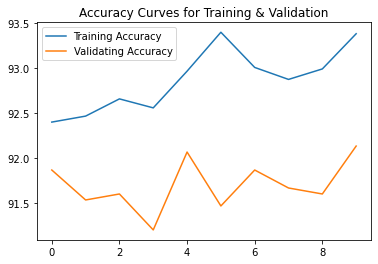

In [0]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

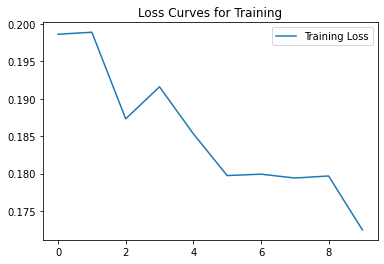

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


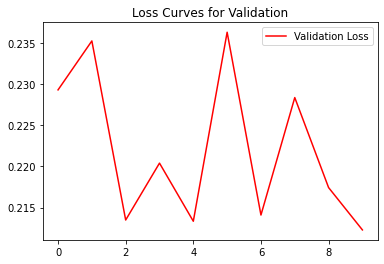

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


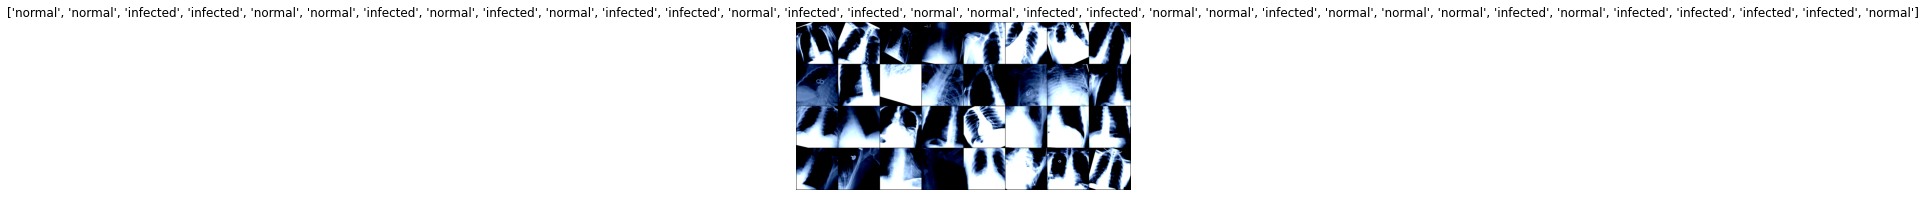

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Training*~



True Normal: 6808
True Infected: 4455
False Normal: 464
False Infected: 273
Precision: 0.9361936193619362
Recall: 0.9614461234288942
F1 Score: 0.948651849787501
Accuracy of the network on the images: 93 %


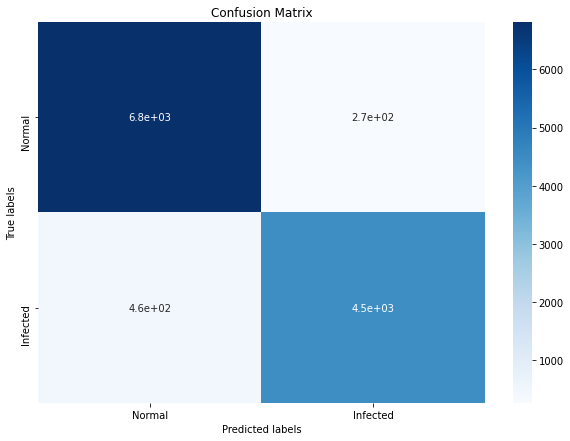

In [0]:
resnet_Model_results(trainloader)

### Validation Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


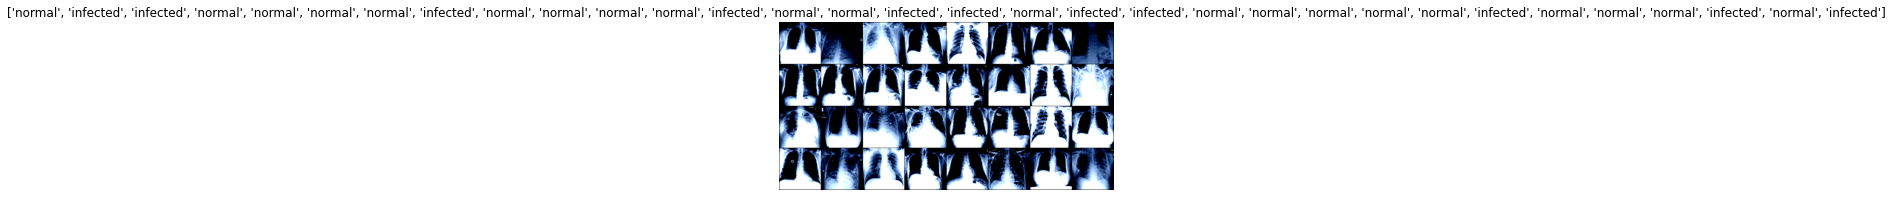

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Validation*~



True Normal: 822
True Infected: 552
False Normal: 63
False Infected: 63
Precision: 0.9288135593220339
Recall: 0.9288135593220339
F1 Score: 0.9288135593220339
Accuracy of the network on the images: 91 %


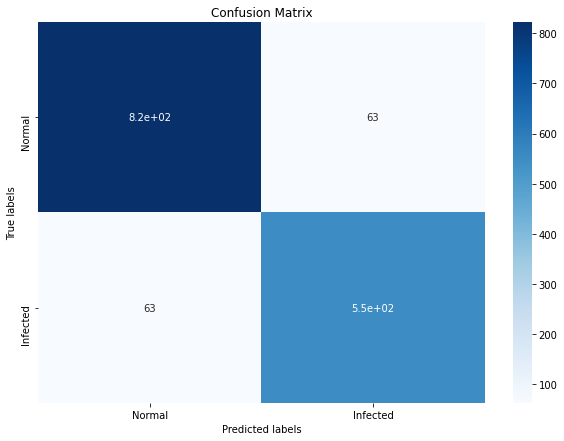

In [0]:
resnet_Model_results(validloader)

### Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


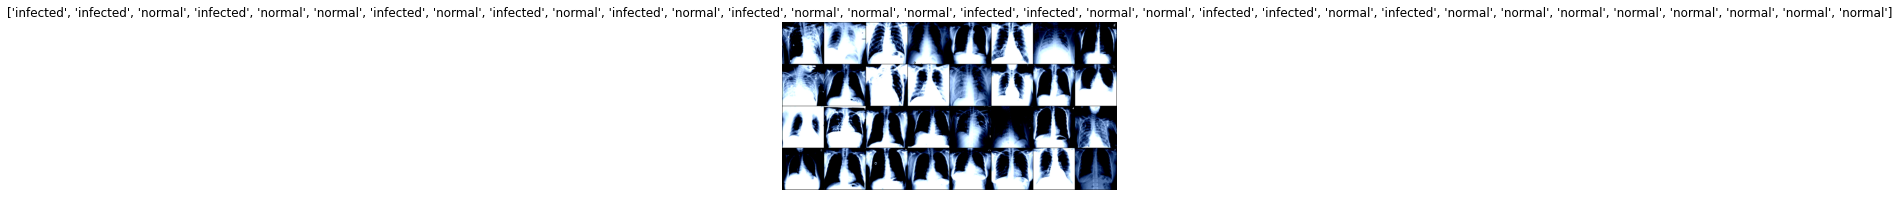

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Testing*~



True Normal: 873
True Infected: 592
False Normal: 23
False Infected: 12
Precision: 0.9743303571428571
Recall: 0.9864406779661017
F1 Score: 0.9803481190342505
Accuracy of the network on the images: 97 %


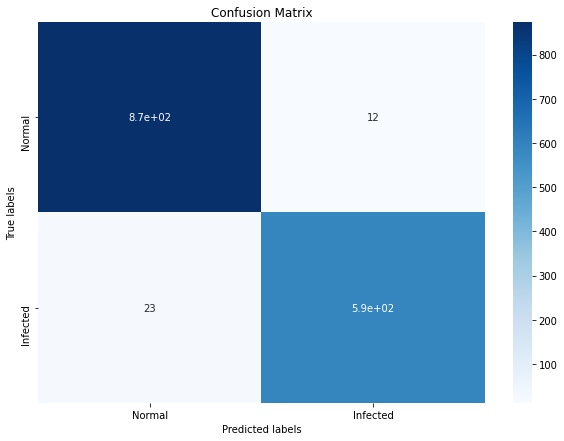

In [0]:
resnet_Model_results(testloader)

In [0]:
torch.save(resnet18.state_dict(), 'resnet18_FC_Only.pth')

# Task 2: VGG-16 Last Convolutional Layer Unfreeze

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
num_features = vgg16.classifier[0].in_features
print(num_features)

25088


In [0]:
features = list(vgg16.classifier.children())[:0] # Remove last layer
print(features)

[]


In [0]:
# Freeze training 26 all layers
i=0
for param in vgg16.features.parameters():
    if i<26:
      param.require_grad = False
    i +=1

In [0]:
roll_num_features = (26*10)+100
features.extend([nn.Linear(num_features, roll_num_features)])
features.extend([nn.Linear(roll_num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.004, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics

        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * correct / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')


    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * correct / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.303710: : 375it [03:32,  1.76it/s]

Accuracy: 85 %



Valid Epoch: 0 [1288/1500 (98%)]	Loss: 0.336886: : 47it [00:20,  2.30it/s]

Accuracy: 89 %



Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.407155: : 375it [03:30,  1.78it/s]


Accuracy: 89 %


Valid Epoch: 1 [1288/1500 (98%)]	Loss: 0.593206: : 47it [00:19,  2.38it/s]

Accuracy: 89 %



Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.226781: : 375it [03:26,  1.81it/s]


Accuracy: 90 %


Valid Epoch: 2 [1288/1500 (98%)]	Loss: 0.164289: : 47it [00:19,  2.40it/s]

Accuracy: 90 %



Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.326649: : 375it [03:26,  1.81it/s]


Accuracy: 90 %


Valid Epoch: 3 [1288/1500 (98%)]	Loss: 0.132429: : 47it [00:19,  2.37it/s]

Accuracy: 90 %



Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.316485: : 375it [03:28,  1.80it/s]


Accuracy: 91 %


Valid Epoch: 4 [1288/1500 (98%)]	Loss: 0.325381: : 47it [00:19,  2.39it/s]

Accuracy: 91 %



Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.166088: : 375it [03:29,  1.79it/s]


Accuracy: 91 %


Valid Epoch: 5 [1288/1500 (98%)]	Loss: 0.263917: : 47it [00:19,  2.38it/s]

Accuracy: 91 %



Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.372945: : 375it [03:28,  1.79it/s]


Accuracy: 91 %


Valid Epoch: 6 [1288/1500 (98%)]	Loss: 0.150096: : 47it [00:19,  2.39it/s]

Accuracy: 92 %



Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.245654: : 375it [03:28,  1.80it/s]


Accuracy: 91 %


Valid Epoch: 7 [1288/1500 (98%)]	Loss: 0.206209: : 47it [00:19,  2.39it/s]

Accuracy: 90 %



Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.236579: : 375it [03:32,  1.77it/s]


Accuracy: 91 %


Valid Epoch: 8 [1288/1500 (98%)]	Loss: 0.329345: : 47it [00:20,  2.30it/s]

Accuracy: 91 %



Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.100359: : 375it [03:31,  1.77it/s]


Accuracy: 92 %


Valid Epoch: 9 [1288/1500 (98%)]	Loss: 0.206165: : 47it [00:19,  2.37it/s]

Accuracy: 90 %
Finished Training


### Plotting Accuracy & Loss

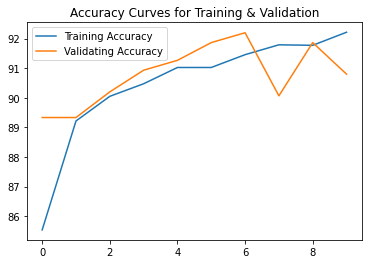

In [0]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

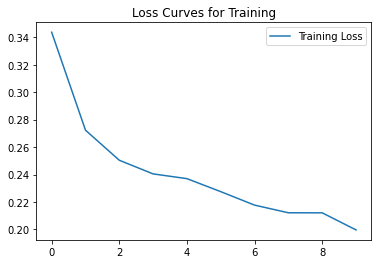

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


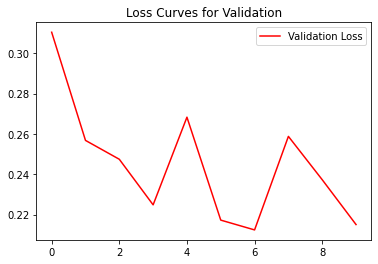

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


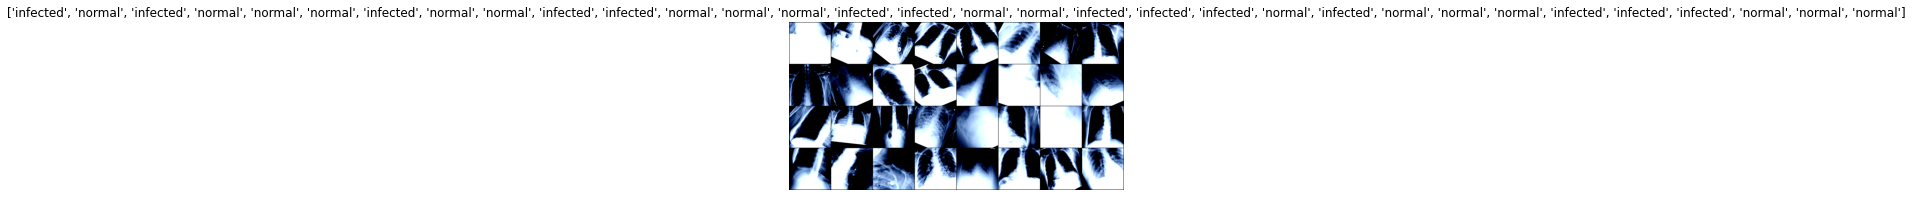

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Training*~



True Normal: 6899
True Infected: 4180
False Normal: 739
False Infected: 182
Precision: 0.9032469232783451
Recall: 0.9742974156192629
F1 Score: 0.9374278143895645
Accuracy of the network on the images: 92 %


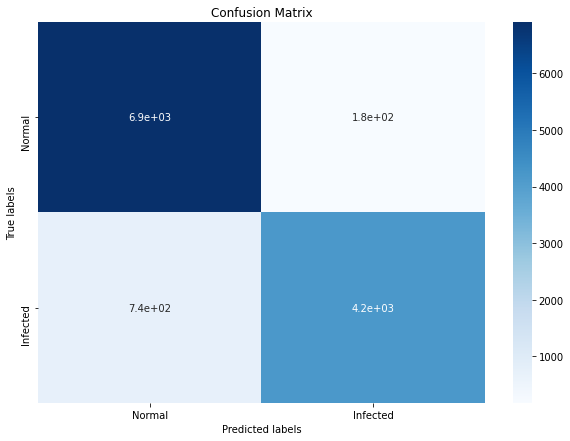

In [0]:
Model_results(trainloader)

### Validation Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


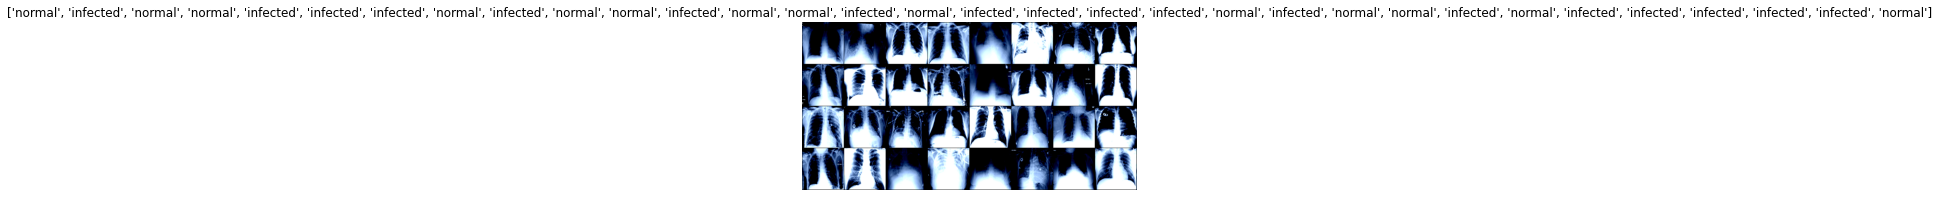

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Validation*~



True Normal: 864
True Infected: 498
False Normal: 117
False Infected: 21
Precision: 0.8807339449541285
Recall: 0.976271186440678
F1 Score: 0.9260450160771704
Accuracy of the network on the images: 90 %


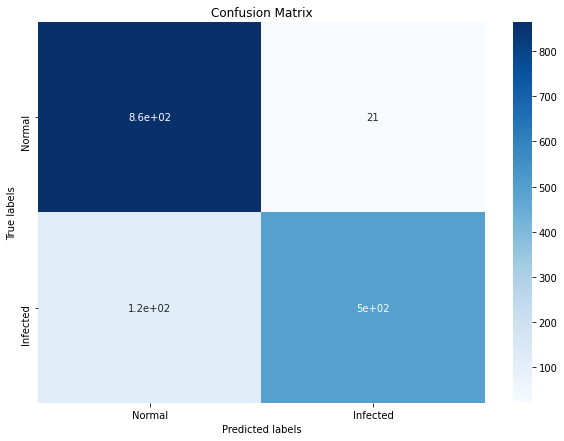

In [0]:
Model_results(validloader)

### Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


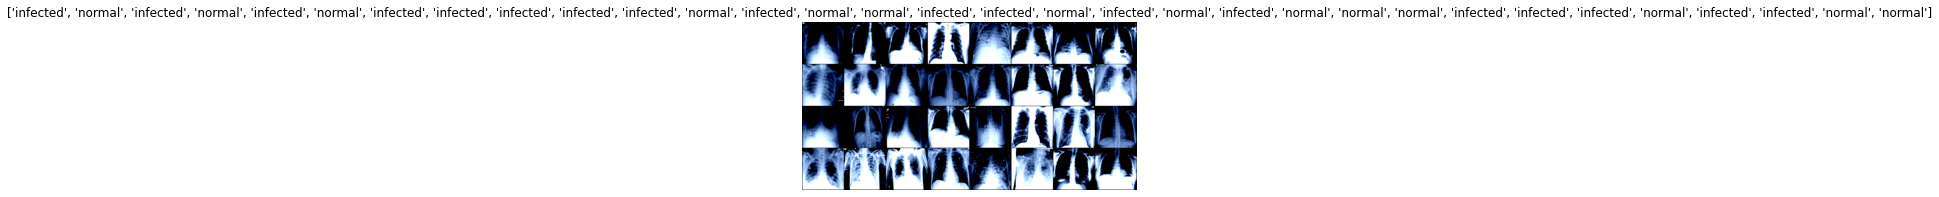

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Testing*~



True Normal: 880
True Infected: 571
False Normal: 44
False Infected: 5
Precision: 0.9523809523809523
Recall: 0.9943502824858758
F1 Score: 0.9729132117191819
Accuracy of the network on the images: 96 %


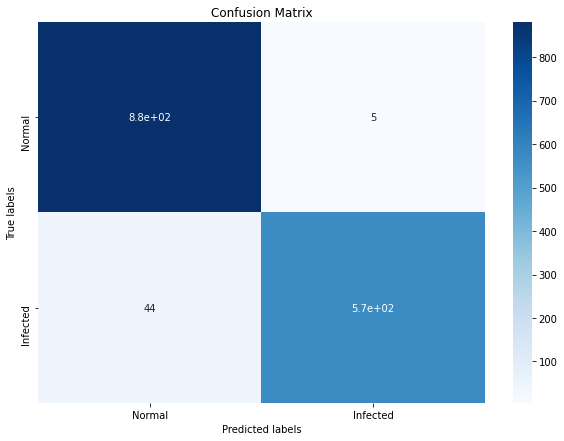

In [0]:
Model_results(testloader)

# Task 2: VGG-16 All Layer Unfreeze

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
num_features = vgg16.classifier[0].in_features
print(num_features)

25088


In [0]:
features = list(vgg16.classifier.children())[:0] # Remove last layer
print(features)

[]


In [0]:
roll_num_features = (26*10)+100
features.extend([nn.Linear(num_features, roll_num_features)])
features.extend([nn.Linear(roll_num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.004, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics

        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * correct / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')


    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * correct / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.116754: : 375it [03:31,  1.77it/s]


Accuracy: 85 %


Valid Epoch: 0 [1288/1500 (98%)]	Loss: 0.110824: : 47it [00:19,  2.38it/s]

Accuracy: 89 %



Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.122749: : 375it [03:30,  1.78it/s]


Accuracy: 89 %


Valid Epoch: 1 [1288/1500 (98%)]	Loss: 0.183767: : 47it [00:20,  2.32it/s]

Accuracy: 90 %



Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.318098: : 375it [03:34,  1.75it/s]


Accuracy: 90 %


Valid Epoch: 2 [1288/1500 (98%)]	Loss: 0.182841: : 47it [00:20,  2.31it/s]

Accuracy: 91 %



Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.129235: : 375it [03:34,  1.75it/s]


Accuracy: 90 %


Valid Epoch: 3 [1288/1500 (98%)]	Loss: 0.189361: : 47it [00:20,  2.32it/s]

Accuracy: 90 %



Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.458358: : 375it [03:31,  1.77it/s]


Accuracy: 91 %


Valid Epoch: 4 [1288/1500 (98%)]	Loss: 0.269366: : 47it [00:20,  2.33it/s]

Accuracy: 91 %



Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.360958: : 375it [03:32,  1.77it/s]


Accuracy: 91 %


Valid Epoch: 5 [1288/1500 (98%)]	Loss: 0.291044: : 47it [00:19,  2.36it/s]

Accuracy: 92 %



Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.381369: : 375it [03:30,  1.78it/s]


Accuracy: 91 %


Valid Epoch: 6 [1288/1500 (98%)]	Loss: 0.110341: : 47it [00:20,  2.34it/s]

Accuracy: 91 %



Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.221636: : 375it [03:34,  1.75it/s]


Accuracy: 91 %


Valid Epoch: 7 [1288/1500 (98%)]	Loss: 0.221318: : 47it [00:19,  2.36it/s]

Accuracy: 91 %



Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.236848: : 375it [03:30,  1.78it/s]


Accuracy: 91 %


Valid Epoch: 8 [1288/1500 (98%)]	Loss: 0.118784: : 47it [00:20,  2.34it/s]

Accuracy: 91 %



Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.260823: : 375it [03:30,  1.79it/s]


Accuracy: 92 %


Valid Epoch: 9 [1288/1500 (98%)]	Loss: 0.329865: : 47it [00:19,  2.36it/s]

Accuracy: 92 %
Finished Training


### Plotting Accuracy & Loss

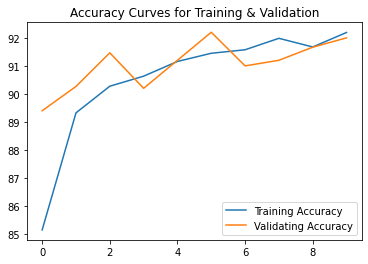

In [0]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

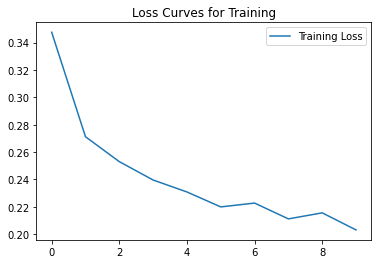

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


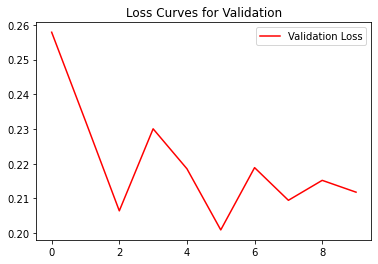

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


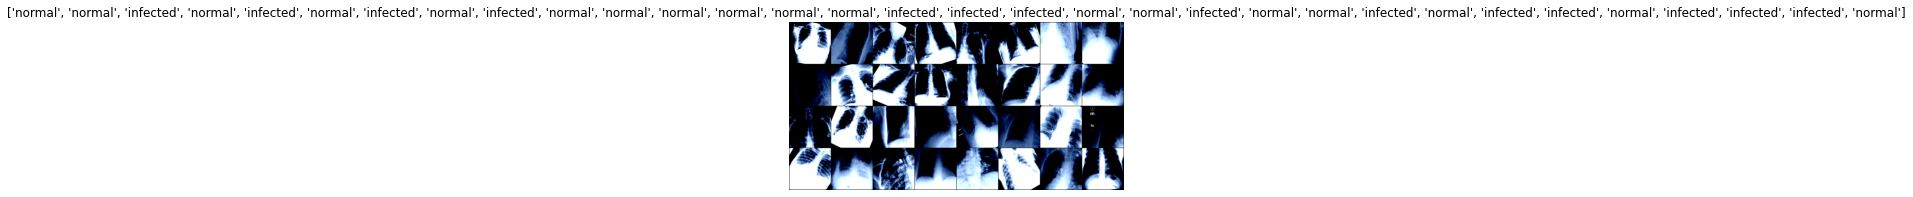

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Training*~



True Normal: 6769
True Infected: 4289
False Normal: 630
False Infected: 312
Precision: 0.9148533585619678
Recall: 0.9559384267758791
F1 Score: 0.9349447513812156
Accuracy of the network on the images: 92 %


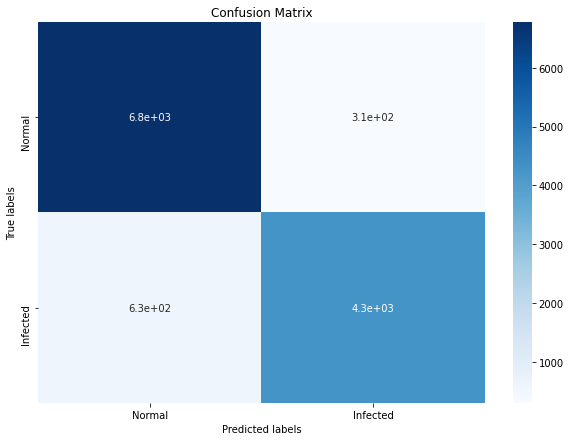

In [0]:
Model_results(trainloader)

### Validation Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


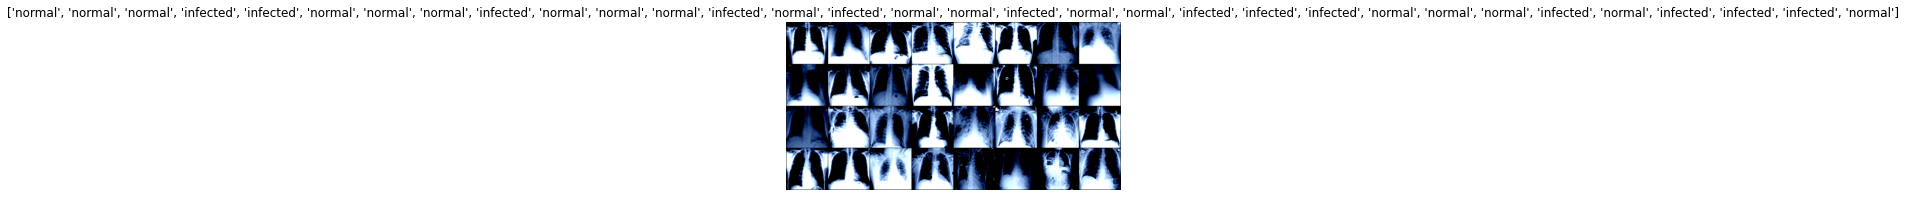

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Validation*~



True Normal: 848
True Infected: 532
False Normal: 83
False Infected: 37
Precision: 0.9108485499462943
Recall: 0.9581920903954803
F1 Score: 0.9339207048458149
Accuracy of the network on the images: 92 %


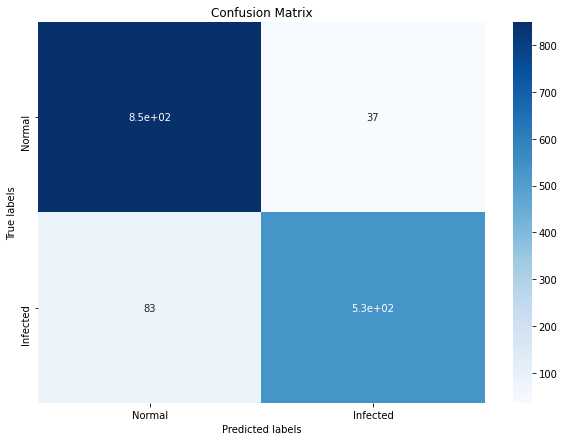

In [0]:
Model_results(validloader)

### Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


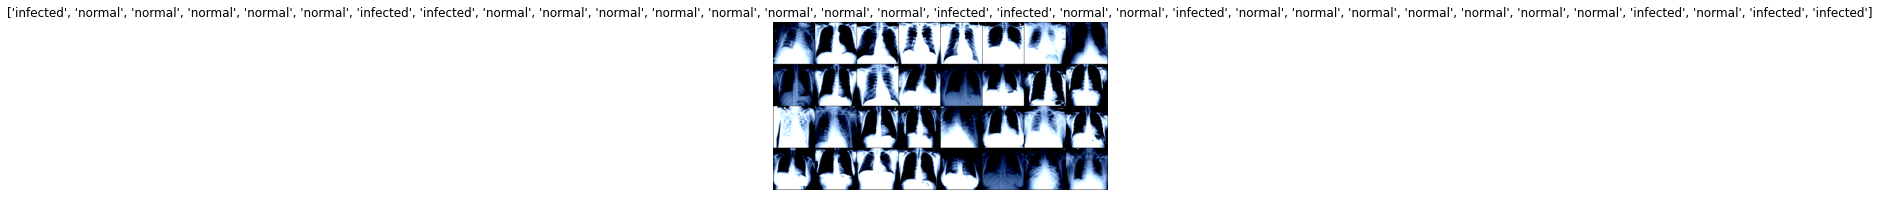

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Testing*~



True Normal: 877
True Infected: 578
False Normal: 37
False Infected: 8
Precision: 0.9595185995623632
Recall: 0.9909604519774011
F1 Score: 0.9749861033907726
Accuracy of the network on the images: 97 %


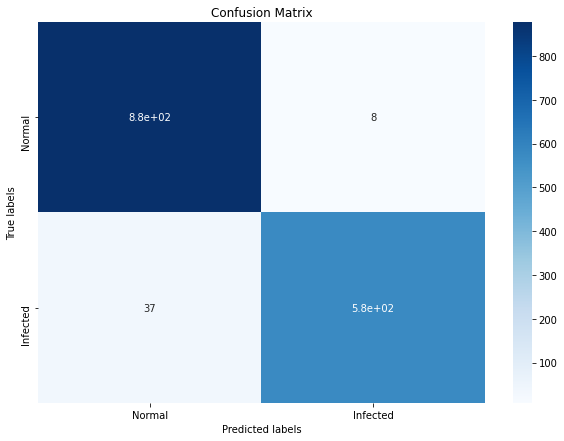

In [0]:
Model_results(testloader)

In [0]:
model_save_name = 'vgg16_entire.pth.pt'
model = vgg16
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

## Task2: ResNet-18 Last Convolution Layer Unfreeze

### Loading Pretrained Model

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained= True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freezing upto last layers

In [0]:
features =[]
# Freeze training for all layers
i=1
for param in resnet18.parameters():
  if i < 58:
    param.require_grad = False
  i+=1
  

### Replacing FC layers

In [0]:
num_features = resnet18.fc.in_features
roll_num_features = (26*10)+100
features.extend([nn.Linear(num_features, roll_num_features)])
features.extend([nn.Linear(roll_num_features, len(class_names))])
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.004, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics

        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * correct / len(train_data))
    train_loss.append(running_loss)
    print('Train Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')


    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * correct / len(valid_data))
    valid_loss.append(running_loss)
    print('Valid Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.346238: : 375it [03:15,  1.92it/s]


Train Accuracy: 86 %


Valid Epoch: 0 [1288/1500 (98%)]	Loss: 0.111311: : 47it [00:19,  2.44it/s]

Valid Accuracy: 89 %



Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.481702: : 375it [03:13,  1.94it/s]

Train Accuracy: 90 %



Valid Epoch: 1 [1288/1500 (98%)]	Loss: 0.285857: : 47it [00:19,  2.43it/s]

Valid Accuracy: 91 %



Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.132543: : 375it [03:16,  1.91it/s]


Train Accuracy: 90 %


Valid Epoch: 2 [1288/1500 (98%)]	Loss: 0.129019: : 47it [00:19,  2.47it/s]

Valid Accuracy: 91 %



Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.138600: : 375it [03:14,  1.93it/s]


Train Accuracy: 91 %


Valid Epoch: 3 [1288/1500 (98%)]	Loss: 0.316589: : 47it [00:19,  2.46it/s]

Valid Accuracy: 90 %



Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.084262: : 375it [03:13,  1.93it/s]

Train Accuracy: 91 %



Valid Epoch: 4 [1288/1500 (98%)]	Loss: 0.529049: : 47it [00:19,  2.44it/s]

Valid Accuracy: 91 %



Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.085835: : 375it [03:14,  1.92it/s]


Train Accuracy: 91 %


Valid Epoch: 5 [1288/1500 (98%)]	Loss: 0.143210: : 47it [00:19,  2.45it/s]

Valid Accuracy: 91 %



Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.346492: : 375it [03:16,  1.91it/s]


Train Accuracy: 91 %


Valid Epoch: 6 [1288/1500 (98%)]	Loss: 0.613019: : 47it [00:19,  2.44it/s]

Valid Accuracy: 90 %



Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.155718: : 375it [03:16,  1.91it/s]

Train Accuracy: 91 %



Valid Epoch: 7 [1288/1500 (98%)]	Loss: 0.249751: : 47it [00:19,  2.43it/s]

Valid Accuracy: 91 %



Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.183440: : 375it [03:17,  1.90it/s]


Train Accuracy: 92 %


Valid Epoch: 8 [1288/1500 (98%)]	Loss: 0.174034: : 47it [00:19,  2.42it/s]

Valid Accuracy: 90 %



Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.321979: : 375it [03:17,  1.90it/s]


Train Accuracy: 92 %


Valid Epoch: 9 [1288/1500 (98%)]	Loss: 0.173508: : 47it [00:19,  2.44it/s]

Valid Accuracy: 91 %
Finished Training


### Plotting Accuracy & Loss

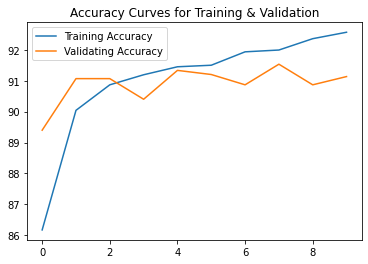

In [0]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

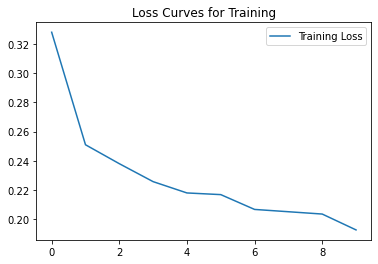

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


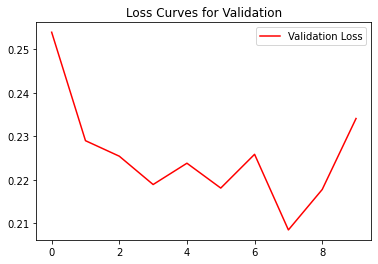

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


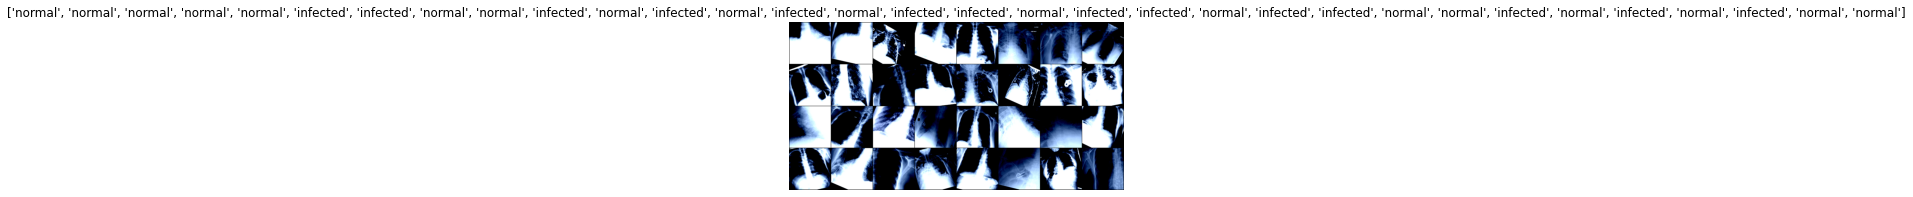

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Training*~



True Normal: 6834
True Infected: 4282
False Normal: 637
False Infected: 247
Precision: 0.914736983000937
Recall: 0.965117921197571
F1 Score: 0.9392523364485982
Accuracy of the network on the images: 92 %


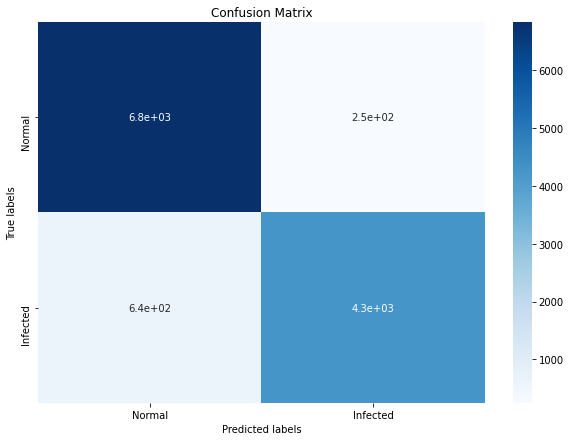

In [0]:
resnet_Model_results(trainloader)

### Validation Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


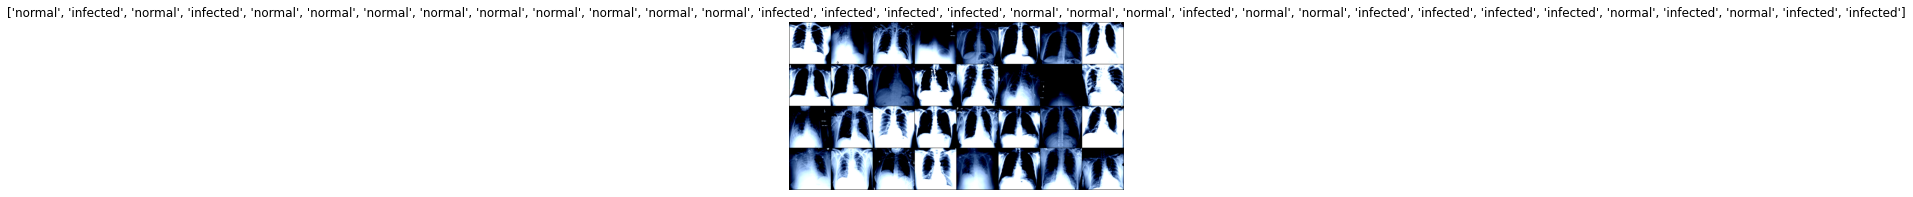

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Validation*~



True Normal: 846
True Infected: 515
False Normal: 100
False Infected: 39
Precision: 0.8942917547568711
Recall: 0.9559322033898305
F1 Score: 0.9240851993446204
Accuracy of the network on the images: 90 %


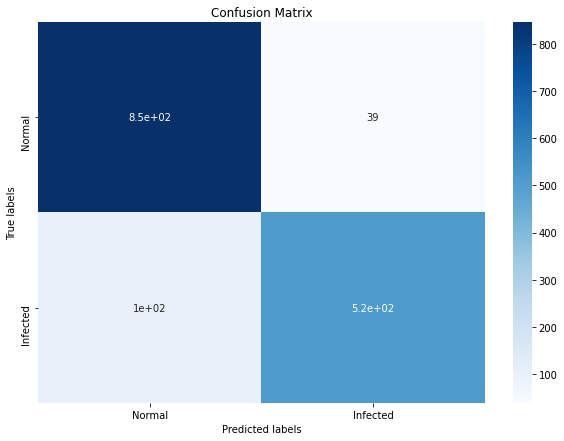

In [0]:
resnet_Model_results(validloader)

### Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


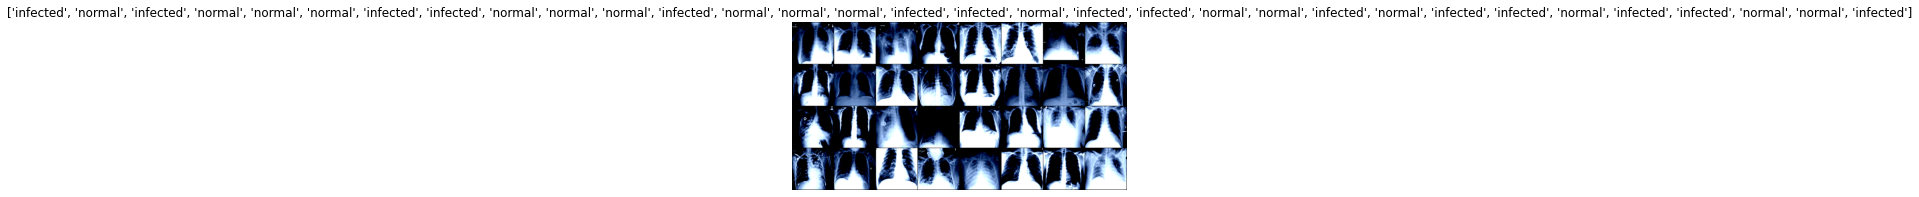

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Testing*~



True Normal: 879
True Infected: 576
False Normal: 39
False Infected: 6
Precision: 0.9575163398692811
Recall: 0.9932203389830508
F1 Score: 0.9750415973377704
Accuracy of the network on the images: 97 %


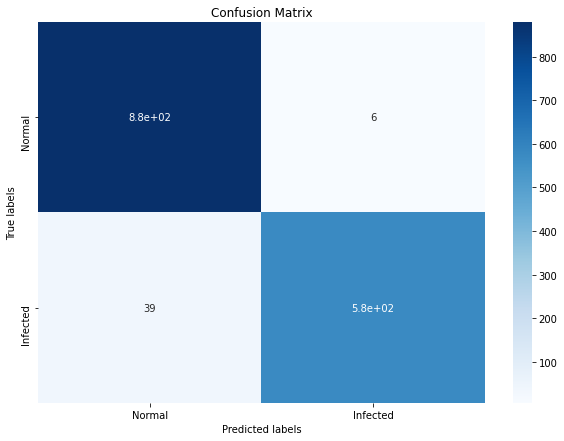

In [0]:
resnet_Model_results(testloader)

## Task2: ResNet-18 All Layers Unfreeze

### Loading Pretrained Model

In [8]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained= True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

### Replacing FC layers

In [9]:
features =[]
num_features = resnet18.fc.in_features
roll_num_features = (26*10)+100
features.extend([nn.Linear(num_features, roll_num_features)])
features.extend([nn.Linear(roll_num_features, len(class_names))])
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.004, momentum=0.9)

In [11]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics

        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * correct / len(train_data))
    train_loss.append(running_loss)
    print('Train Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')


    correct = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * correct / len(valid_data))
    valid_loss.append(running_loss)
    print('Valid Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.249763: : 375it [03:12,  1.95it/s]


Train Accuracy: 86 %


Valid Epoch: 0 [1288/1500 (98%)]	Loss: 0.199351: : 47it [00:19,  2.39it/s]

Valid Accuracy: 89 %



Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.171457: : 375it [03:10,  1.97it/s]


Train Accuracy: 89 %


Valid Epoch: 1 [1288/1500 (98%)]	Loss: 0.277312: : 47it [00:18,  2.54it/s]

Valid Accuracy: 90 %



Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.133949: : 375it [03:07,  2.00it/s]

Train Accuracy: 90 %



Valid Epoch: 2 [1288/1500 (98%)]	Loss: 0.199692: : 47it [00:18,  2.53it/s]

Valid Accuracy: 90 %



Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.102007: : 375it [03:09,  1.98it/s]


Train Accuracy: 91 %


Valid Epoch: 3 [1288/1500 (98%)]	Loss: 0.182035: : 47it [00:18,  2.54it/s]

Valid Accuracy: 91 %



Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.127758: : 375it [03:05,  2.02it/s]

Train Accuracy: 91 %



Valid Epoch: 4 [1288/1500 (98%)]	Loss: 0.194228: : 47it [00:18,  2.59it/s]

Valid Accuracy: 90 %



Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.172841: : 375it [03:05,  2.02it/s]


Train Accuracy: 92 %


Valid Epoch: 5 [1288/1500 (98%)]	Loss: 0.626354: : 47it [00:18,  2.58it/s]

Valid Accuracy: 91 %



Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.496609: : 375it [03:04,  2.03it/s]


Train Accuracy: 92 %


Valid Epoch: 6 [1288/1500 (98%)]	Loss: 0.219745: : 47it [00:18,  2.60it/s]

Valid Accuracy: 90 %



Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.141955: : 375it [03:04,  2.03it/s]

Train Accuracy: 92 %



Valid Epoch: 7 [1288/1500 (98%)]	Loss: 0.064844: : 47it [00:18,  2.56it/s]

Valid Accuracy: 90 %



Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.067341: : 375it [03:05,  2.03it/s]


Train Accuracy: 92 %


Valid Epoch: 8 [1288/1500 (98%)]	Loss: 0.089809: : 47it [00:18,  2.60it/s]

Valid Accuracy: 91 %



Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.086584: : 375it [03:04,  2.03it/s]

Train Accuracy: 92 %



Valid Epoch: 9 [1288/1500 (98%)]	Loss: 0.171335: : 47it [00:18,  2.56it/s]

Valid Accuracy: 91 %
Finished Training


### Plotting Accuracy & Loss

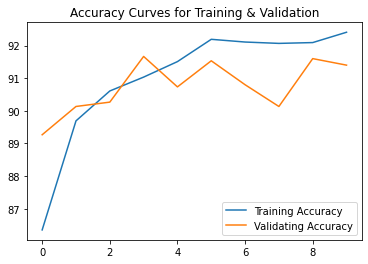

In [12]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

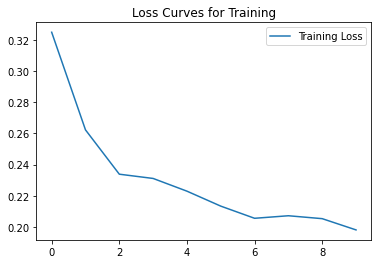

In [13]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


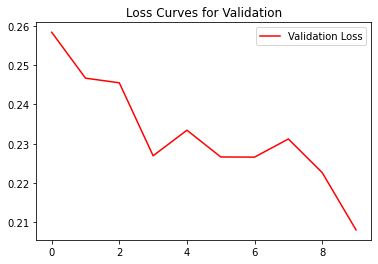

In [14]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


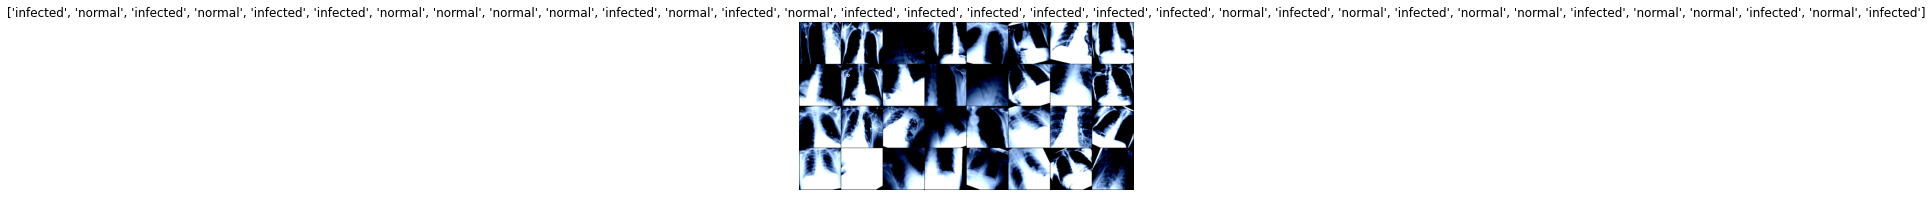

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Training*~



True Normal: 6842
True Infected: 4271
False Normal: 648
False Infected: 239
Precision: 0.9134846461949265
Recall: 0.9662477051263946
F1 Score: 0.9391256605586439
Accuracy of the network on the images: 92 %


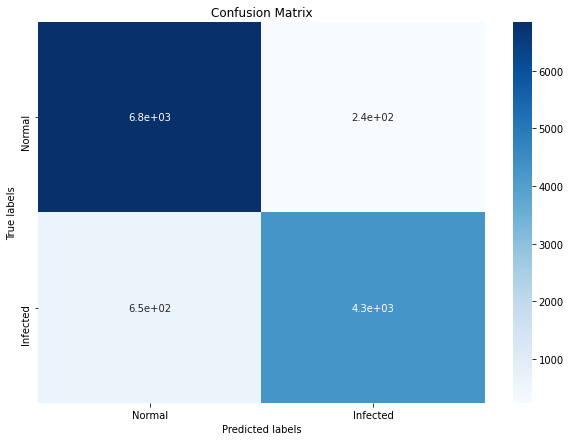

In [16]:
resnet_Model_results(trainloader)

### Validation Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


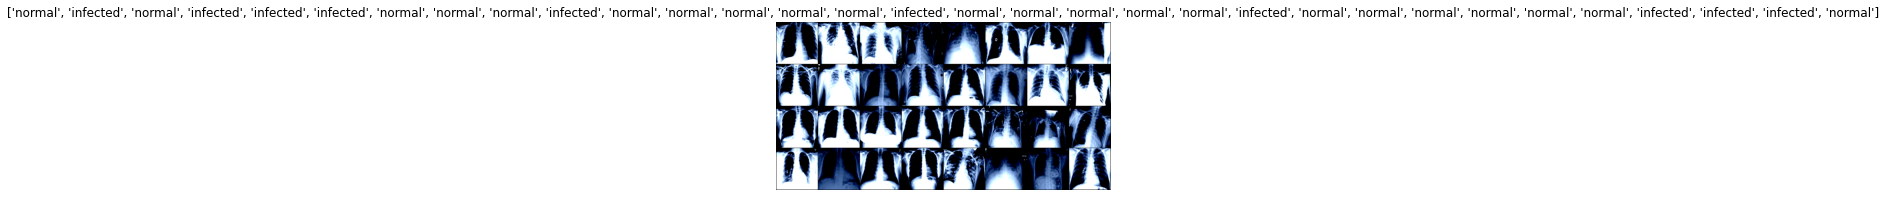

In [17]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Validation*~



True Normal: 836
True Infected: 529
False Normal: 86
False Infected: 49
Precision: 0.9067245119305857
Recall: 0.9446327683615819
F1 Score: 0.9252905368013282
Accuracy of the network on the images: 91 %


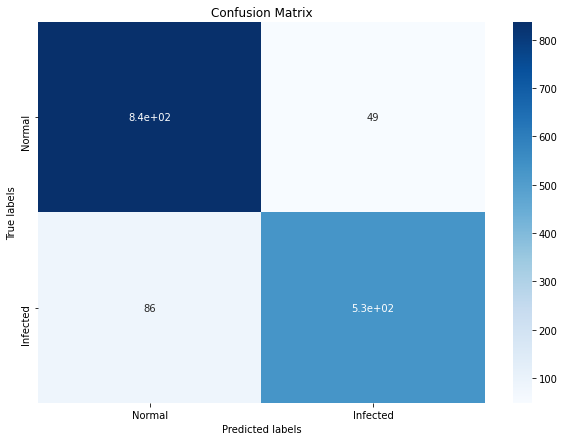

In [18]:
resnet_Model_results(validloader)

### Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


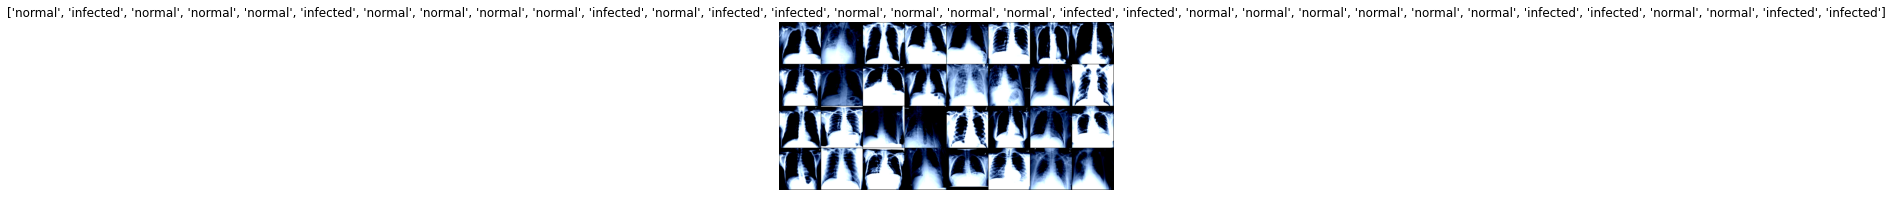

In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

~*Loading Results for Testing*~



True Normal: 880
True Infected: 569
False Normal: 46
False Infected: 5
Precision: 0.9503239740820735
Recall: 0.9943502824858758
F1 Score: 0.9718387631143016
Accuracy of the network on the images: 96 %


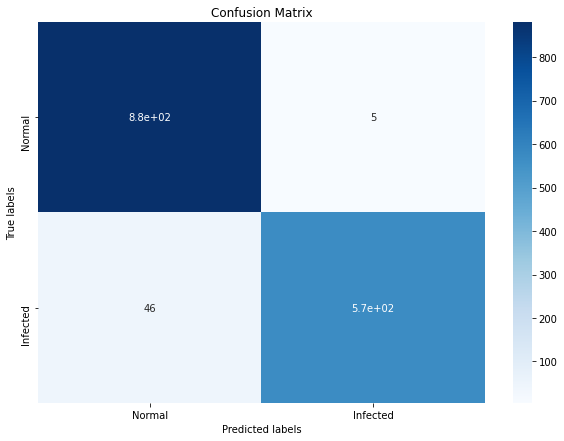

In [20]:
resnet_Model_results(testloader)

In [0]:
model_save_name = 'resnet18_entire.pth.pt'
model = resnet18
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)